_________
# Installing Torch and Dependencies
We will use hugging face transformers to load and use BERT. I used the following for installation:
```
pip install -U pip setuptools wheel
pip install torch torchvision
pip install transformers
pip install pillow
pip install tensorflow-macos tensorflow-metal
pip install numpy==1.23.5
pip install tf-keras==2.16
```
Since hugging face is commonly built for PyTorch, that is also what we will use.

In [1]:
# NOTE: When installing torch, use the instructions from here: https://pytorch.org/get-started/locally/
#  You should be using pip or pip3 to install on your system. This ensures GPU support is added, if possible. 
import torch
print(f"Torch: {torch.__version__}")
print(f"MPS: {torch.backends.mps.is_available()}") # able to use Apple Metal Performance Shaders (MPS)? 
device = torch.device("mps")

Torch: 2.5.1
MPS: True


In [2]:
# we are also going to use hugging face, which requires the use of tensorflow
# NOTE: The version of numpy used is NOT the latest, I had to downgrade for compatibility
import tensorflow as tf
print(f"Tensorflow: {tf.__version__}")

import numpy as np
print(f"NumPy: {np.__version__}")

Tensorflow: 2.16.2
NumPy: 1.23.5


In [3]:
# hugging face also requires a separate tf-keras install (which must also be a downgraded version)
import tf_keras
tf_keras.__version__

'2.16.0'

_____
# A Brief Explanation of BERT
BERT stands for Bidirectional Encoder Representations from Transformers and it trains a modest sized transformer architecture in a few ways: 
- Next Sentence Prediction (NSP), should two sentences should logically follow each other?
- Masked Language Model (Masked LM), if some words are masked, can the model guess the masked words correctly based on the other words in the document.
- Two version exists: BERT-base (12 encoder layers) vs. BERT-large (24 encoder layers)
- Hugging face offers open source trained models for BERT that are accesisble using PyTorch: https://huggingface.co/google-bert/bert-base-uncased

Note also that there are some implementations that subsume the transfer learning, but these methods also hide some of the nuances and control. Common examples might look like the following:

```python
 # Define training arguments
 training_args = TrainingArguments(
     output_dir='./results',
     eval_strategy="epoch",
     per_device_train_batch_size= ...,
     per_device_eval_batch_size= ...,
     num_train_epochs= ...,
     weight_decay= ... ,
 )

 # Define the Trainer
 trainer = Trainer(
     model=model,
     args=training_args,
     train_dataset=train_data,
     eval_dataset=eval_data,
 )

# Train the model
trainer.train()
```

However, the code for transfer learning typically needs to be more agile and adaptable than these API methods allow. Therefore, we need a bit more in-depth tutorial on using transfer learning.

There are some existing resources for transfer learning from BERT, like the following:
- A repository fine tuning all of BERT on 20 news groups: https://github.com/CSCfi/machine-learning-scripts/blob/master/examples/pytorch_20ng_bert.py
- An in depth look from kaggle on transfer learning with IMdB: https://www.kaggle.com/code/pashupatigupta/transfer-learning-using-bert-in-depth

_____
# Loading BERT

**TODO: Add more BERT Explanation. Mark as experimental until this explanation is finalized.**

- **Overall Architecture**
  - Input Processing: Words are first tokenized and embedded using words embeddings. 
  - Encoder: Embeddings are fed into transformer layers. Many transformer layers are employed. Pre-trained weights in the encoder capture general linguistic patterns (e.g., syntax, semantics). During fine-tuning, the encoder layers are often partially or fully updated to adapt to the specific task.
  - Pooling Module: Determines how the encoder outputs are aggregated for the downstream task. This changes depending upon how transfer learning will be employed. For example:
    - (1) Entire Sequence Classification tasks: Use the [CLS] token embedding.
    - (2) Sequence labeling tasks (e.g., Named Entity Recognition): Use token embeddings directly.
    - (3) Text similarity tasks: Use embeddings from both sequences for comparison.
- **Input Processing**
  - To make text understandable to BERT, it converts the input into a fixed format:
    - Tokens: The text is split into subwords using the WordPiece tokenizer in BERT. 
    - Token Embeddings: Each token is mapped to a dense vector using an embedding matrix. The embedding size for each word is 768 elements. 
    - Segment Embeddings: Different segments (e.g., sentence A vs. sentence B) are marked for tasks involving pairs of sentences.
    - Positional Embeddings: Added to token embeddings to encode token order in the sequence. Since transformers do not have a built-in notion of sequence order, BERT adds these embeddings to represent token positions.
    - The final input is the sum of these three embeddings.
  - A note on the CLS Token Representation: BERT introduces a special [CLS] token at the beginning of every input sequence and an ending [SEP] token to the end of each sequence.  After the encoder processes the sequence, the output embedding corresponding to the [CLS] token is treated as a holistic representation of the entire input. This [CLS] embedding is often passed through a task-specific pooling head for downstream tasks like sequence classification.
- **Transformer Encoder** (12-24 transformer layers):
  - BERT is built on the transformer encoder architecture, which processes text as a sequence of tokens using self-attention and feed-forward layers. The key elements for each transformer include:
    - Multi-Head Self-Attention: Helps the model focus on different parts of the input text simultaneously.
    - Feed-Forward Neural Networks (FFNNs): Applied to each token independently after attention mechanisms.
    - Layer Normalization: Each sub-layer (attention and FFNN) is followed by layer normalization to stabilize training.
    - Residual Connections: Residual (skip) connections are added around both the self-attention and feed-forward layers to help the model retain information and avoid vanishing gradients.
  - The hidden size of the encoder (768 for BERT-base) determines the dimensionality of token embeddings.
Each encoder layer maintains the same hidden size, with a total of approximately 110 million parameters in the base model.
  - The 12 encoder layers are stacked sequentially, with each layer refining the token embeddings using increasingly complex contextual information.
  - The final output of the encoder is a tensor with shape
(batch size, sequence length, hidden size), representing contextualized embeddings for all tokens.
- **Pooling Module**
  - The pooling module is used to aggregate the sequence of token embeddings generated by the encoder into a single fixed-size representation. This is crucial for tasks that require a single representation of the input, such as classification.


In [4]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Load a pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels=20,
                                                      output_hidden_states=False
                                                     )
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In the above loading, we explicitly did NOT load the hidden layers as outputs. That means that the intermediate activations from BERT are not exposed outside the computation graph. Only the output of the model (the 20 classes we setup) are exposed. 

If we wanted to access these intermediate activations (for each token and each layer of BERT), it would greatly increase the number of parameters that we need to access after a feedforward pass. This is a bit slower to run, but it would allow us to do different transfer learning. As an example, accessing the hidden layer outputs can be achieved with the following code:
```python
model = Bert[...].from_pretrained(... output_hidden_states=True ...)

# get the model output
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

# the hidden states is organized by the layers in BERT and the tokens
token = 0 # the position of the token within BERT, '0' is the CLS token
layer = -1 # the final layer of BERT, before pooling is applied
output.hidden_states[layer][0][token]

```
the results would be a 768 element vector for the CLS token in the last layer of BERT

In [5]:
# now lets place the model on a GPU, for much better parallelism 
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Notice that BERT is loaded -- however, the very last layer is not trained. That is, we asked torch to load the model and then create a final linear layer with a specific number of outputs (i.e., neurons). This layer is randomly initialized and needs to be trained. You might also see a "Warning" that `['classifier.bias', 'classifier.weight']` are newly created and need to be trained for proper usage. 

This version of BERT is specifically designed for transfer learning to new data, based on sequence classification. It is also possible to load the BERT weights and use them for the MSK and NSP tasks, but this requires loading the BERT model with some additional code that can interpret the outputs. We will not do that here--just load the model with an extra untrained layer. 

In the example below, we can first tokenize a sentence and then send it through the model. It will output 20 different logit values.

In [6]:
text = "Larson has examples that are great, aren't they?!"
encoded_input = tokenizer(text, return_tensors='pt') # pt is the PyTorch model

# By default, the tokenizer will add a [CLS] and [SEP] token to the example, tokens 101 and 102
# The tokenizer will also tokenize some punctuations, some words into multiple tokens
#  like superlatives and contractions, etc.
print(f"Number of words in text: {len(text.split(' '))}, Number of tokens: {len(encoded_input.input_ids[0])}")
print(f"{encoded_input.input_ids[0]}")

Number of words in text: 8, Number of tokens: 15
tensor([  101, 21213,  2038,  4973,  2008,  2024,  2307,  1010,  4995,  1005,
         1056,  2027,  1029,   999,   102])


Notice that the number of tokens is more than just the words and punctuation. In the above example, there are 15 tokens corresponding to the following breakdown of the sentence:


|[CLS]|[Larson]|[has]|[examples]|[that]|[are]|[great]|[,]|[aren]|[']|[t]|[they]|[?]|[!]|[SEP]|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|101|21213|2038|4973|2008|2024|2307|1010|4995|1005|1056|2027|1029|999|102|

In [7]:
# send the tensors to the proper device (like GPU or CPU)
# when using torch, you need to explicitly define where the tensors are stored
# since we are using the MPS (GPU) of an Apple M-series, we need to transfer the 
# tensors to that device. The model is already loaded on the GPU.
for k in encoded_input.keys():
    encoded_input[k] = encoded_input[k].to(device)

# by default, operations will have gradients tracked, which we do not need unless
#  we are performing back propagation, so let's tell torch NOT to calculate gradients
with torch.no_grad():
    output = model(**encoded_input)
output.logits

tensor([[ 0.6088,  0.0798,  0.8314,  0.3452,  0.4662, -0.3856,  0.2378,  0.1696,
         -0.3789,  0.2657, -0.5577,  0.0195,  0.0027,  0.0075,  0.5333,  0.9178,
         -0.0915,  0.1581,  0.1158, -0.3524]], device='mps:0')

So now we have a way to access the output of BERT and a way to access the pooled output of BERT that is about 768 units. This is the vector that can be used for training the final layer. But now we can access it and save the bottleneck features. 

Let's use this on another dataset, the 20 newsgroups data.

In [8]:
# Let's load a simple dataset for training the BERT model. 
from sklearn.datasets import fetch_20newsgroups

bunch = fetch_20newsgroups()
print(f"Found {len(bunch.data)} documents and {len(bunch.target)} labels with unique values of {np.unique(bunch.target)}")

# take an example from here and send into our model
example = bunch.data[0]
encoded_input = tokenizer(example, return_tensors='pt') # pt is the PyTorch model

# By default, the tokenizer will add a [CLS] and [SEP] token to the example, tokens 101 and 102
# The tokenizer will also tokenize some punctuations, some words into multiple tokens
#  like superlatives and contractions, etc.
print(f"Number of words in text: {len(example.split(' '))}, Number of tokens: {len(encoded_input.input_ids[0])}")

print(encoded_input)
print(example)

Found 11314 documents and 11314 labels with unique values of [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Number of words in text: 114, Number of tokens: 201
{'input_ids': tensor([[  101,  2013,  1024,  3393,  2099,  2595,  3367,  1030, 11333,  2213,
          1012,  8529,  2094,  1012,  3968,  2226,  1006,  2073,  1005,  1055,
          2026,  2518,  1007,  3395,  1024,  2054,  2482,  2003,  2023,   999,
          1029,  1050,  3372,  2361,  1011, 14739,  1011,  3677,  1024, 10958,
          2278,  2509,  1012, 11333,  2213,  1012,  8529,  2094,  1012,  3968,
          2226,  3029,  1024,  2118,  1997,  5374,  1010,  2267,  2380,  3210,
          1024,  2321,  1045,  2001,  6603,  2065,  3087,  2041,  2045,  2071,
          4372,  7138,  2368,  2033,  2006,  2023,  2482,  1045,  2387,  1996,
          2060,  2154,  1012,  2009,  2001,  1037,  1016,  1011,  2341,  2998,
          2482,  1010,  2246,  2000,  2022,  2013,  1996,  2397, 20341,  1013,
          2220, 17549

In [9]:
# take an example from here and send into our model
example = bunch.data[0]
encoded_input = tokenizer(example, return_tensors='pt') # pt is the PyTorch model
# send to GPU
for k in encoded_input.keys():
    encoded_input[k] = encoded_input[k].to(device)
# get model output
output = model(**encoded_input)
print(output)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.4932, -0.2563,  0.6848,  0.0898,  0.6126, -0.6445,  0.0484,  0.0019,
         -0.4107, -0.0189, -0.4953,  0.0605,  0.2645, -0.0702,  0.4867,  0.6376,
         -0.1905,  0.0841,  0.0987, -0.1744]], device='mps:0',
       grad_fn=<LinearBackward0>), hidden_states=None, attentions=None)


Tokenizing:   0%|          | 0/11314 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors


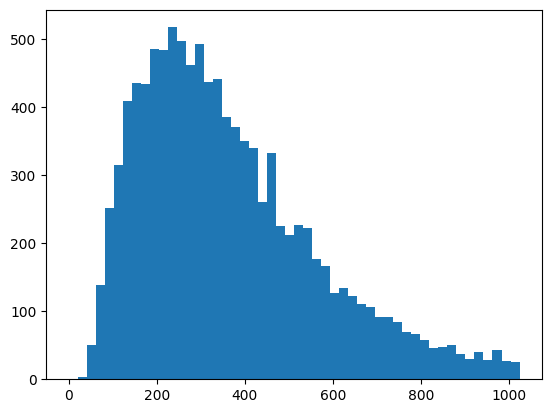

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm, trange

text_lengths = np.zeros(bunch.target.shape)
for idx, (text, label) in enumerate(tqdm(zip(bunch.data, bunch.target), desc="Tokenizing", total=len(bunch.target))): 

    # here we will tokenize a bit differently, in order to create same length vectors and masks
    # we need the tokenized outputs to all be the same length for speeding up computation
    encoded_example = tokenizer(text, return_tensors='pt')

    text_lengths[idx] = len(encoded_example.input_ids[0])

plt.hist(text_lengths, range=(0,1024), bins=50)
plt.show()

# Preprocessing the BERT Tokenizer
We need to process all the news groups data here such that it is the same length. To do this, we will use truncation and padding (which are included parameters in the tokenizer). By making each entry the same lenght, we can store the values more efficiently, and provide them to the model for training more rapidly. This speed up for truncation and padding explanation was given in CS7324, and mainly stems from not needing to reconfigure the computation graph (a costly operation). It also allows for batching of the data much more easily.

So what is the maximum length of document we should allow? The above plot shows that the median document length is around 200 tokens (but can be much longer). BERT also has a practical constraint that it can only process 512 tokens. A reasonable choice is to select about 256 tokens, which means most texts will not be truncated. This is only a 'guess' about the length. A more in depth answer would require that we train different models with varying context lengths, then select based on a validation set. Since we are just now starting out, let's leave that analysis to future work. 

In [11]:


# Loop through the newsgroups dataset and save all the outputs of each of the 
#   tensors so that we can more easily place them through BERT for training
max_seq_length = 256 # limit of BERT to process sequence length is 512
encoded_dataset = []
samples_processed = 0
for text, label in tqdm(zip(bunch.data, bunch.target), desc="Encoding", total=len(bunch.target)): 

    # here we will tokenize a bit differently, in order to create same length vectors and masks
    # we need the tokenized outputs to all be the same length for speeding up computation
    encoded_example = tokenizer(text, return_tensors='pt', 
                                truncation=True, 
                                padding='max_length',
                                max_length=max_seq_length)

    # add one more dictionary entry for the label
    encoded_example['label_id'] = label 

    assert len(encoded_example.input_ids[0]) == max_seq_length

    encoded_dataset.append(encoded_example)

print(f"Encoded {len(encoded_dataset)} texts, saving with the following fields: {encoded_dataset[0].keys()}")



Encoding:   0%|          | 0/11314 [00:00<?, ?it/s]

Encoded 11314 texts, saving with the following fields: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'label_id'])


In [12]:
# here is an example of what we are about to do to combine the tensors in the next cell
tmp = torch.cat([d.input_ids for d in encoded_dataset], dim=0)
print(tmp.size())
tmp

torch.Size([11314, 256])


tensor([[ 101, 2013, 1024,  ...,    0,    0,    0],
        [ 101, 2013, 1024,  ...,    0,    0,    0],
        [ 101, 2013, 1024,  ..., 1037, 2514,  102],
        ...,
        [ 101, 2013, 1024,  ...,    0,    0,    0],
        [ 101, 2013, 1024,  ..., 1018, 2685,  102],
        [ 101, 2013, 1024,  ...,    0,    0,    0]])

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data import random_split

BATCH_SIZE = 16
TRAIN_PERC = 0.8 # want 80% for training

total_len = len(bunch.target) # total number documents
train_size = int(TRAIN_PERC*total_len) # number of docs to get to train percentage
eval_size = total_len - train_size # and remainder for evaluation

# Need to create dataset from 'input_ids', 'token_type_ids', 'attention_mask', 'label_id'
# concatenate the tensors to make one large tensor (each row is a document)
all_data = TensorDataset(torch.cat([d.input_ids for d in encoded_dataset], dim=0),
                           torch.cat([d.attention_mask for d in encoded_dataset], dim=0), 
                           torch.cat([d.token_type_ids for d in encoded_dataset], dim=0), 
                           torch.tensor([d.label_id for d in encoded_dataset], dtype=torch.long)
                          )

train_data, eval_data = random_split(all_data, [train_size, eval_size])

# sample at random from these tensors and setup a loader to loop through the model
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

print(f"Created two datasets training/eval. Training samples: {train_size}, Evaluation: {eval_size}")

# free up some memory, already saved in the new dataset
del encoded_dataset

Created two datasets training/eval. Training samples: 9051, Evaluation: 2263


# Train BERT
Now let's train the model in a loop. This is similar to the use of tf GradientTape that we covered in CS7324. We set the model to be in training mode with `model.train()` and then we iterative place examples through the model and update the parameters. 

Let's start with just placing an example through and calculating the loss function. Then we will iterate over the loader so that we can run back propagation in a loop. 

The BERT pre-trained model already has a cross entropy loss calculation built-in, which we will use in our examples. However, we could manually calculate our loss function using something like the following code:

```python
from torch.nn import CrossEntropyLoss

# this will be our loss funcion
loss_func = CrossEntropyLoss()
output = model([...]) # get model outputs
loss = loss_func(output.logits, labels)
```

In [14]:
# grab one batch
batch = next(iter(train_dataloader))
input_ids, input_mask, input_types, labels = batch

# place these examples through model
output = model(input_ids.to(device), input_types.to(device), input_mask.to(device), labels=labels.to(device))
# output.loss is already part of the given model, added as the loss function for 
#  this specific pre-trained BERT model. It was added along with the 
#  final classifier layers when we loaded the model. 

print(f"There are {len(output.logits)} samples in the batch, each of size {len(output.logits[0])}")
print(f"The total loss value is {output.loss}")

There are 16 samples in the batch, each of size 20
The total loss value is 3.1718976497650146


In [15]:
# setup some tracking
history = {}
history['val_loss'] = []
history['train_loss'] = []

from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler

TOTAL_EPOCHS = 5 # small number of epochs here in to classifier and pooler working together

# only train the final layer of BERT
# in our example, the final layer was called 'classifier', as shown in the summary above
for param in model.parameters():
    param.requires_grad = False

# only train the parameters for pooler and the classifier
for param in model.bert.pooler.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

train_params = list(model.bert.pooler.parameters()) + list(model.classifier.parameters())

# we can now tell the optimizer to only optimize these parameters in the model
optimizer = Adam(train_params)


In [16]:


# setup a nice progress bar (tracking epochs), and keep a reference to it for showing validation loss
with trange(TOTAL_EPOCHS, desc="Epoch") as pbar:
    for epoch in pbar:
        # set model to training mode (i.e., use dropout and other training specific operations)
        model.train()
        total_loss = 0.0
        # do one epoch of training
        for batch in tqdm(train_dataloader, desc=f"Training {epoch}", total=int(train_size/BATCH_SIZE)+1, leave=False):
            
            # send batch to GPU and separate for the model
            batch = tuple(s.to(device) for s in batch)
            input_ids, input_mask, input_types, labels = batch
    
            # because we give the labels, loss is also calculated
            output = model(input_ids, input_types, input_mask, labels=labels)
    
            # back propagation 
            output.loss.backward() # register loss and perform gradient calculations
            optimizer.step() # use gradients in optimizer
            optimizer.zero_grad() # clear out gradients

            # keep track of train loss
            total_loss += output.loss.item() * BATCH_SIZE
            
            #NOTE: could also accumulate gradient here to artificially expand batch size, 
            # and extend time between optimizer updates 

        total_loss = total_loss / train_size
        history['train_loss'].append(total_loss)
        
        # at end of epoch, report the evaluation
        model.eval()  # Set model to evaluation mode
        total_loss = 0.0
    
        with torch.no_grad():
            for batch in tqdm(eval_dataloader, desc=f"Evaluating {epoch}", total=int(eval_size/BATCH_SIZE)+1, leave=False):
                batch = tuple(s.to(device) for s in batch) # send to GPU
                input_ids, input_mask, input_types, labels = batch
            
                output = model(input_ids, input_types, input_mask, labels=labels)
                # calculate the total loff for the batch (per item)
                total_loss += output.loss.item() * BATCH_SIZE
            # after iterating through all, divide by total number of samples
            total_loss = total_loss / eval_size
            history['val_loss'].append(total_loss)
        # print the eval loss in the progress bar for the epochs
        pbar.set_postfix(loss=f"{total_loss:.2f}")


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training 0:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 0:   0%|          | 0/142 [00:00<?, ?it/s]

Training 1:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 1:   0%|          | 0/142 [00:00<?, ?it/s]

Training 2:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 2:   0%|          | 0/142 [00:00<?, ?it/s]

Training 3:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 3:   0%|          | 0/142 [00:00<?, ?it/s]

Training 4:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 4:   0%|          | 0/142 [00:00<?, ?it/s]

In [17]:
all_preds = []
all_labels = []

model.eval() # set model to evalaution mode (no dropout, etc.)

# run the evaluation without tracking gradient operations
with torch.no_grad():
    for batch in tqdm(eval_dataloader,desc="Evaluating", total=int(eval_size/BATCH_SIZE)+1):
        
        batch = tuple(s.to(device) for s in batch) # send to GPU
        input_ids, input_mask, input_types, labels = batch
        
        output = model(input_ids, input_types, input_mask, labels=None)

        # save these model outputs as numpy arrays.
        # 1. We need to detach the tensors from the computation graph
        # 2. then copy the tensor over to the cpu (from the GPU)
        # 3. then convert to numpy
        # 4. save this numpy vector in a list of other vectors
        # we will stack the vectors from the list into one big numpy vector later on
        all_preds.append(  output.logits.detach().cpu().numpy() )
        all_labels.append( labels.cpu().numpy() )

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

0.4078656650463986


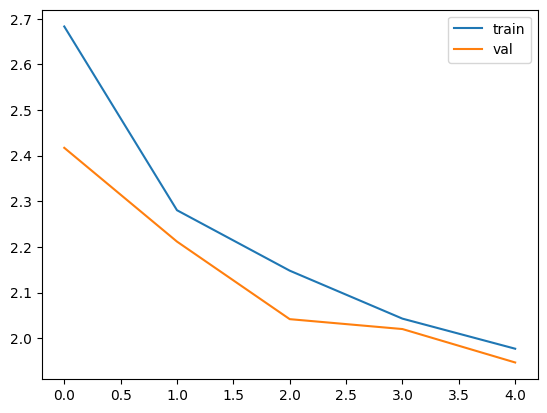

In [18]:
from sklearn.metrics import accuracy_score

# combine the individual batched outputs and argmax for the predictions

# stack lable array into vector of class index, [0, 5, 19, ... , 12, 13]
labels_array = np.hstack(all_labels)
# stack each prediction into matrix where row=[net outpu array] and col=[each class probaability]
# take argmax across each netowrk output (row) to collapse these into a vector of int classes [1, 5, 19, ... , 11, 13]
preds_array = np.argmax(np.vstack(all_preds), axis=1)

# now that the preds and labels are in a similar format, we can compare with sklearn metrics
print(accuracy_score(labels_array, preds_array))

plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.show()

In [19]:
# access the final layer of BERT, before the pooler
# we will use only the final pooling layer
model.bert.encoder.layer[-1]

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [20]:
TOTAL_EPOCHS = 100

# unfreeze additional weights for fine tuning
for param in model.parameters():
    param.requires_grad = False

# only train certain parameters 
for param in model.bert.encoder.layer[-2].parameters():
    param.requires_grad = True
    
for param in model.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

for param in model.bert.pooler.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

#named_parameters = list(model.classifier.named_parameters()) + list(model.bert.pooler.named_parameters()) + list(model.bert.encoder.layer[-1].output.named_parameters())

train_params = list(model.classifier.parameters()) + list(model.bert.pooler.parameters()) + list(model.bert.encoder.layer[-1].parameters()) + list(model.bert.encoder.layer[-2].parameters())

# we can now tell the optimizer to optimize these parameters with given weight decay
optimizer = Adam(train_params)
scheduler = lr_scheduler.LinearLR(optimizer, 
                                  start_factor=0.01, end_factor=0.001, 
                                  total_iters=TOTAL_EPOCHS)


with trange(TOTAL_EPOCHS, desc="Epoch") as pbar:
    for epoch in pbar:
        model.train()
        total_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Training {epoch}", total=int(train_size/BATCH_SIZE)+1, leave=False):
            batch = tuple(s.to(device) for s in batch)
            input_ids, input_mask, input_types, labels = batch    
            output = model(input_ids, input_types, input_mask, labels=labels)
            output.loss.backward() # register loss and perform gradient calculations
            optimizer.step() # use gradients in optimizer
            optimizer.zero_grad() # clear out gradients
            total_loss += output.loss.item() * BATCH_SIZE

        total_loss = total_loss / train_size
        history['train_loss'].append(total_loss)
                
        # reduce the LR between epochs
        scheduler.step()
        
        # at end of epoch, report the evaluation
        model.eval()  # Set model to evaluation mode
        total_loss = 0.0
    
        with torch.no_grad():
            for batch in tqdm(eval_dataloader, desc=f"Evaluating {epoch}", total=int(eval_size/BATCH_SIZE)+1, leave=False):
                batch = tuple(s.to(device) for s in batch) # send to GPU
                input_ids, input_mask, input_types, labels = batch
                output = model(input_ids, input_types, input_mask, labels=labels)
                total_loss += output.loss.item() * BATCH_SIZE
            total_loss = total_loss / eval_size
            history['val_loss'].append(total_loss)
        pbar.set_postfix(loss=f"{total_loss:.2f}")



Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training 0:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 0:   0%|          | 0/142 [00:00<?, ?it/s]

Training 1:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 1:   0%|          | 0/142 [00:00<?, ?it/s]

Training 2:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 2:   0%|          | 0/142 [00:00<?, ?it/s]

Training 3:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 3:   0%|          | 0/142 [00:00<?, ?it/s]

Training 4:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 4:   0%|          | 0/142 [00:00<?, ?it/s]

Training 5:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 5:   0%|          | 0/142 [00:00<?, ?it/s]

Training 6:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 6:   0%|          | 0/142 [00:00<?, ?it/s]

Training 7:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 7:   0%|          | 0/142 [00:00<?, ?it/s]

Training 8:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 8:   0%|          | 0/142 [00:00<?, ?it/s]

Training 9:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 9:   0%|          | 0/142 [00:00<?, ?it/s]

Training 10:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 10:   0%|          | 0/142 [00:00<?, ?it/s]

Training 11:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 11:   0%|          | 0/142 [00:00<?, ?it/s]

Training 12:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 12:   0%|          | 0/142 [00:00<?, ?it/s]

Training 13:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 13:   0%|          | 0/142 [00:00<?, ?it/s]

Training 14:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 14:   0%|          | 0/142 [00:00<?, ?it/s]

Training 15:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 15:   0%|          | 0/142 [00:00<?, ?it/s]

Training 16:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 16:   0%|          | 0/142 [00:00<?, ?it/s]

Training 17:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 17:   0%|          | 0/142 [00:00<?, ?it/s]

Training 18:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 18:   0%|          | 0/142 [00:00<?, ?it/s]

Training 19:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 19:   0%|          | 0/142 [00:00<?, ?it/s]

Training 20:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 20:   0%|          | 0/142 [00:00<?, ?it/s]

Training 21:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 21:   0%|          | 0/142 [00:00<?, ?it/s]

Training 22:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 22:   0%|          | 0/142 [00:00<?, ?it/s]

Training 23:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 23:   0%|          | 0/142 [00:00<?, ?it/s]

Training 24:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 24:   0%|          | 0/142 [00:00<?, ?it/s]

Training 25:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 25:   0%|          | 0/142 [00:00<?, ?it/s]

Training 26:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 26:   0%|          | 0/142 [00:00<?, ?it/s]

Training 27:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 27:   0%|          | 0/142 [00:00<?, ?it/s]

Training 28:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 28:   0%|          | 0/142 [00:00<?, ?it/s]

Training 29:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 29:   0%|          | 0/142 [00:00<?, ?it/s]

Training 30:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 30:   0%|          | 0/142 [00:00<?, ?it/s]

Training 31:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 31:   0%|          | 0/142 [00:00<?, ?it/s]

Training 32:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 32:   0%|          | 0/142 [00:00<?, ?it/s]

Training 33:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 33:   0%|          | 0/142 [00:00<?, ?it/s]

Training 34:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 34:   0%|          | 0/142 [00:00<?, ?it/s]

Training 35:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 35:   0%|          | 0/142 [00:00<?, ?it/s]

Training 36:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 36:   0%|          | 0/142 [00:00<?, ?it/s]

Training 37:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 37:   0%|          | 0/142 [00:00<?, ?it/s]

Training 38:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 38:   0%|          | 0/142 [00:00<?, ?it/s]

Training 39:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 39:   0%|          | 0/142 [00:00<?, ?it/s]

Training 40:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 40:   0%|          | 0/142 [00:00<?, ?it/s]

Training 41:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 41:   0%|          | 0/142 [00:00<?, ?it/s]

Training 42:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 42:   0%|          | 0/142 [00:00<?, ?it/s]

Training 43:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 43:   0%|          | 0/142 [00:00<?, ?it/s]

Training 44:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 44:   0%|          | 0/142 [00:00<?, ?it/s]

Training 45:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 45:   0%|          | 0/142 [00:00<?, ?it/s]

Training 46:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 46:   0%|          | 0/142 [00:00<?, ?it/s]

Training 47:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 47:   0%|          | 0/142 [00:00<?, ?it/s]

Training 48:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 48:   0%|          | 0/142 [00:00<?, ?it/s]

Training 49:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 49:   0%|          | 0/142 [00:00<?, ?it/s]

Training 50:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 50:   0%|          | 0/142 [00:00<?, ?it/s]

Training 51:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 51:   0%|          | 0/142 [00:00<?, ?it/s]

Training 52:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 52:   0%|          | 0/142 [00:00<?, ?it/s]

Training 53:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 53:   0%|          | 0/142 [00:00<?, ?it/s]

Training 54:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 54:   0%|          | 0/142 [00:00<?, ?it/s]

Training 55:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 55:   0%|          | 0/142 [00:00<?, ?it/s]

Training 56:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 56:   0%|          | 0/142 [00:00<?, ?it/s]

Training 57:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 57:   0%|          | 0/142 [00:00<?, ?it/s]

Training 58:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 58:   0%|          | 0/142 [00:00<?, ?it/s]

Training 59:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 59:   0%|          | 0/142 [00:00<?, ?it/s]

Training 60:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 60:   0%|          | 0/142 [00:00<?, ?it/s]

Training 61:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 61:   0%|          | 0/142 [00:00<?, ?it/s]

Training 62:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 62:   0%|          | 0/142 [00:00<?, ?it/s]

Training 63:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 63:   0%|          | 0/142 [00:00<?, ?it/s]

Training 64:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 64:   0%|          | 0/142 [00:00<?, ?it/s]

Training 65:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 65:   0%|          | 0/142 [00:00<?, ?it/s]

Training 66:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 66:   0%|          | 0/142 [00:00<?, ?it/s]

Training 67:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 67:   0%|          | 0/142 [00:00<?, ?it/s]

Training 68:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 68:   0%|          | 0/142 [00:00<?, ?it/s]

Training 69:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 69:   0%|          | 0/142 [00:00<?, ?it/s]

Training 70:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 70:   0%|          | 0/142 [00:00<?, ?it/s]

Training 71:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 71:   0%|          | 0/142 [00:00<?, ?it/s]

Training 72:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 72:   0%|          | 0/142 [00:00<?, ?it/s]

Training 73:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 73:   0%|          | 0/142 [00:00<?, ?it/s]

Training 74:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 74:   0%|          | 0/142 [00:00<?, ?it/s]

Training 75:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 75:   0%|          | 0/142 [00:00<?, ?it/s]

Training 76:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 76:   0%|          | 0/142 [00:00<?, ?it/s]

Training 77:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 77:   0%|          | 0/142 [00:00<?, ?it/s]

Training 78:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 78:   0%|          | 0/142 [00:00<?, ?it/s]

Training 79:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 79:   0%|          | 0/142 [00:00<?, ?it/s]

Training 80:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 80:   0%|          | 0/142 [00:00<?, ?it/s]

Training 81:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 81:   0%|          | 0/142 [00:00<?, ?it/s]

Training 82:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 82:   0%|          | 0/142 [00:00<?, ?it/s]

Training 83:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 83:   0%|          | 0/142 [00:00<?, ?it/s]

Training 84:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 84:   0%|          | 0/142 [00:00<?, ?it/s]

Training 85:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 85:   0%|          | 0/142 [00:00<?, ?it/s]

Training 86:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 86:   0%|          | 0/142 [00:00<?, ?it/s]

Training 87:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 87:   0%|          | 0/142 [00:00<?, ?it/s]

Training 88:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 88:   0%|          | 0/142 [00:00<?, ?it/s]

Training 89:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 89:   0%|          | 0/142 [00:00<?, ?it/s]

Training 90:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 90:   0%|          | 0/142 [00:00<?, ?it/s]

Training 91:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 91:   0%|          | 0/142 [00:00<?, ?it/s]

Training 92:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 92:   0%|          | 0/142 [00:00<?, ?it/s]

Training 93:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 93:   0%|          | 0/142 [00:00<?, ?it/s]

Training 94:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 94:   0%|          | 0/142 [00:00<?, ?it/s]

Training 95:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 95:   0%|          | 0/142 [00:00<?, ?it/s]

Training 96:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 96:   0%|          | 0/142 [00:00<?, ?it/s]

Training 97:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 97:   0%|          | 0/142 [00:00<?, ?it/s]

Training 98:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 98:   0%|          | 0/142 [00:00<?, ?it/s]

Training 99:   0%|          | 0/566 [00:00<?, ?it/s]

Evaluating 99:   0%|          | 0/142 [00:00<?, ?it/s]

In [21]:
all_preds = []
all_labels = []

model.eval() # set model to evalaution mode (no dropout, etc.)

# run the evaluation without tracking gradient operations
with torch.no_grad():
    for batch in tqdm(eval_dataloader,desc="Evaluating", total=int(eval_size/BATCH_SIZE)+1):
        
        batch = tuple(s.to(device) for s in batch) # send to GPU
        input_ids, input_mask, input_types, labels = batch
        
        output = model(input_ids, input_types, input_mask, labels=None)

        # save these model outputs as numpy arrays.
        # 1. We need to detach the tensors from the computation graph
        # 2. then copy the tensor over to the cpu (from the GPU)
        # 3. then convert to numpy
        # 4. save this numpy vector in a list of other vectors
        # we will stack the vectors from the list into one big numpy vector later on
        all_preds.append(  output.logits.detach().cpu().numpy() )
        all_labels.append( labels.cpu().numpy() )

Evaluating:   0%|          | 0/142 [00:00<?, ?it/s]

0.5952275740167918


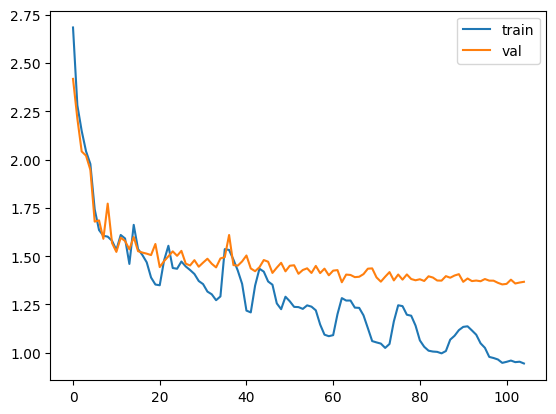

In [22]:
# combine the individual batched outputs and argmax for the predictions

# stack lable array into vector of class index, [0, 5, 19, ... , 12, 13]
labels_array = np.hstack(all_labels)
# stack each prediction into matrix where row=[net outpu array] and col=[each class probaability]
# take argmax across each netowrk output (row) to collapse these into a vector of int classes [1, 5, 19, ... , 11, 13]
preds_array = np.argmax(np.vstack(all_preds), axis=1)

# now that the preds and labels are in a similar format, we can compare with sklearn metrics
print(accuracy_score(labels_array, preds_array))

plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.show()

_______
**Instructor Notes:**

Housekeeping in experimental branch:
- Using hooks and loading the hidden layers as outputs caused crashing of the kernel. Potentially a memory leak of calculating the various gradients. Need to try with, 'no_grad'.
- At a sequence of 128, using optimizer on classifier first, then pooler+classifier, achieved 52% train acc (0.5211242708149195). No eval set was yet created. 
- At a sequence of 256, with optimizer pooler+classifier, achieved 0.424 acc on eval. Debugged a number of trials to monitor the outputs.
  - after additional learning rate reduction, this increased to 51.25% eval
_______

# Using hooks to save intermediate activations

**Hooks currently cause out of memory errors. Need to debug if this is from the computation graph not being used properly.**

While the above example was able to successfuly use transfer learning, there were some parts that are clearly inefficient. For example, most of the BERT model remains untrained. Only the pooler and classifier layers are trained. Given this, why should we be running the encoder for BERT over an over in each epoch? 

It might be more efficient to save the intermediate activations from the model with a hook function. A hook is an operation that can be tied to any layer in Torch such that it saves off intermediate activations into a global variable. The 'hook' must be a function handle, so we wrap it in another function. The input to the wrapper function is a key for saving the activations into a global variable. For example, the following code can be used to register a hook. This is a manipulated code snippet from the following example:
- https://github.com/RabiaGondur/CNNfeatureExtraction/blob/main/CNN_Feature_Extractor.ipynb

```python
# get access to one part of our model using a forward hook
# this will continually save activations into a global dictionary 
embeds = {}
def get_activation(name):
    def hook(model, input, output):
        embeds[name] = output
    return hook
    
model.bert.pooler.register_forward_hook(get_activation('bottleneck_features'))

# take an example from here and send into our model
output = model(**encoded_input)

# then in the encoding loop, put sample through Bert (and save the hook)
output = model(**encoded_example)
encoded_example['bottleneck_features'] = embeds['bottleneck_features']
```